# Loyalty Cards

## Executive summary

In this notebook I will perform the MDE for loyalty cards experiment

## Config

In [110]:
# import matplotlib.pyplot as  plt
# import numpy as np
import pandas as pd
# import seaborn as sns
import os
import sys

base_path = 'c:/Users/Jordi Cremades/Documents/Repos/customer-data-analytics-main/'
sys.path.insert(1, os.path.join(base_path, 'General/AB-tests/MDE'))
sys.path.insert(2, os.path.join(base_path, 'General/AB-tests'))

sys.path.append('c:/Users/Jordi Cremades/Documents/Repos/central-node')

from utils import query_engines
from fenix.statistical_tests import relative_ttest as t_test
from fenix.run_experiment import ExperimentConfig, MDEConfig, ExperimentRunner
from fenix.statistical_tests.stattools import StatisticalResult
from fenix.tools.helpfuncs import mde_visualization
from fenix.tools.helpfuncs import adjusted_alpha_multiple_comparison

import transformations.transformation as tr
import fenix.visual.graphs
import fenix.tools.hashing as hashing

## [X] Build the dataset

In [129]:
q = query_engines.QueryEngines(reset_query_logs=True, reset_to_load=False)

START_DATE = "'2024-05-01'"
END_DATE = "'2024-06-01'"

params = [
    # dates
    {'name':'start_date', 'value': str(START_DATE)},
    {'name':'end_date', 'value': str(END_DATE)},
]

q.prepare_query('lc_mde.sql', params=params)

df  = q.query_run_starburst( #query_run_livedb otherwise
    output_file='lc_mde',
    load_from_output_file=None,
    print_query=True
)

df.head()

c:\Users/Jordi Cremades/Documents/Repos/central-node\utils\query_engines.py:235: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(self.tp__read_query, conn)


Open the following URL in browser for the external authentication:
https://starburst.g8s-data-platform-prod.glovoint.com/oauth2/token/initiate/b886c19b73b05281507fe35b76453e97b77e97bb29b0b4caef6d481ed82561b9


,customer_id,first_exposure_date,exposure_week_index_since_start_date,obs_week_index_since_start_date,n_orders,n_orders_with_loyalty,n_store_views
0,162976,2024-05-17,3,4,2,1,1
1,593395,2024-05-02,1,1,1,1,1
2,593395,2024-05-02,1,2,5,3,5
3,593395,2024-05-02,1,3,9,5,12
4,593395,2024-05-02,1,4,15,7,18


In [130]:
# Definition of main metric
df['lc_pen']=df['n_orders_with_loyalty']/df['n_orders']
df['lc_pen'].fillna(0,inplace=True)
df.head()

,customer_id,first_exposure_date,exposure_week_index_since_start_date,obs_week_index_since_start_date,n_orders,n_orders_with_loyalty,n_store_views,lc_pen
0,162976,2024-05-17,3,4,2,1,1,0.500000
1,593395,2024-05-02,1,1,1,1,1,1.000000
2,593395,2024-05-02,1,2,5,3,5,0.600000
3,593395,2024-05-02,1,3,9,5,12,0.555556
4,593395,2024-05-02,1,4,15,7,18,0.466667


# [X] Dataset sanity check

<Axes: xlabel='first_exposure_date'>

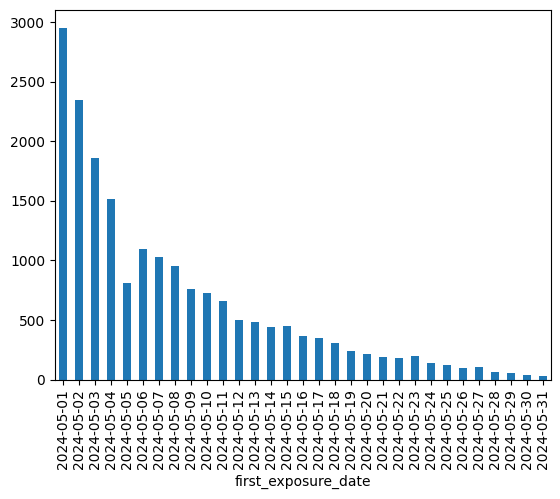

In [131]:
df.groupby('first_exposure_date').customer_id.nunique().plot(kind='bar')

<Axes: xlabel='first_exposure_date'>

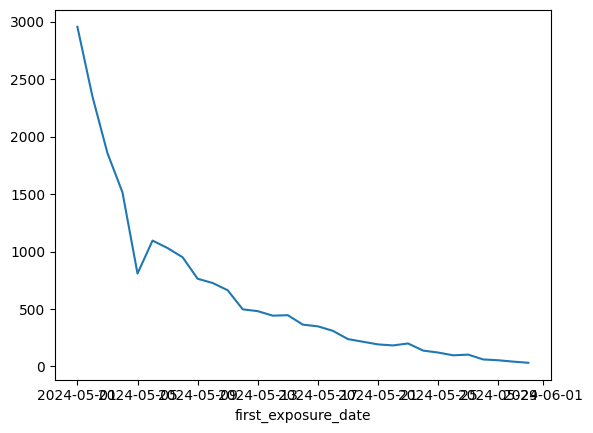

In [132]:
df.groupby('first_exposure_date').customer_id.nunique().plot(kind='line')

<Axes: xlabel='obs_week_index_since_start_date'>

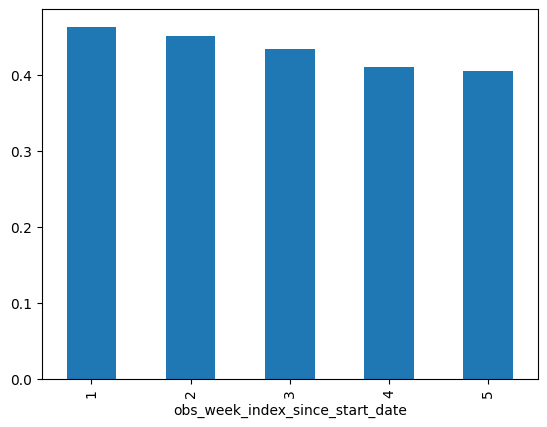

In [133]:
df.groupby('obs_week_index_since_start_date')['lc_pen'].mean().plot(kind='bar')

# Dataset simulation

In [134]:
# Synthetic LTHO group
df['ltho_group'] = df['customer_id'].apply(lambda x: hashing.hashing_function(x, 'a057353b-bdd5-41eb-b62e-d9b488b54367', (49,999)))
df['ltho_group'].value_counts(normalize=True, dropna=False)

ltho_group
variant    0.951217
control    0.048783
Name: proportion, dtype: float64

In [138]:
# Filter out customer that are in the LTHO group
df = df[df['ltho_group']=='variant']

In [139]:
df.sort_values(by='obs_week_index_since_start_date')

,customer_id,first_exposure_date,exposure_week_index_since_start_date,obs_week_index_since_start_date,n_orders,n_orders_with_loyalty,n_store_views,lc_pen,ltho_group
24429,148995806,2024-05-01,1,1,2,2,7,1.000,variant
26792,142868789,2024-05-03,1,1,0,0,2,0.000,variant
5443,131687727,2024-05-06,1,1,1,1,2,1.000,variant
39719,138248349,2024-05-01,1,1,3,3,16,1.000,variant
26795,154163598,2024-05-02,1,1,0,0,3,0.000,variant
...,...,...,...,...,...,...,...,...,...
24164,124318100,2024-05-01,1,5,8,3,27,0.375,variant
13081,9415795,2024-05-23,4,5,0,0,1,0.000,variant
39964,31605061,2024-05-01,1,5,3,3,5,1.000,variant
13097,19768325,2024-05-12,2,5,0,0,1,0.000,variant


In [141]:
sessions_outliers = tr.outliers_detection(df, 'obs_week_index_since_start_date', 'n_orders', 'n_store_views')
sessions_outliers.head()

,customer_id,first_exposure_date,exposure_week_index_since_start_date,obs_week_index_since_start_date,n_orders,n_orders_with_loyalty,n_store_views,lc_pen,ltho_group,cmperorder
22623,18744918,2024-05-01,1,5,20,17,600,0.850000,variant,30.000000
45661,126358051,2024-05-02,1,5,344,27,418,0.078488,variant,1.215116
6193,128331687,2024-05-01,1,5,16,12,360,0.750000,variant,22.500000
17992,132368218,2024-05-01,1,5,23,19,248,0.826087,variant,10.782609
38804,58818211,2024-05-01,1,5,37,18,207,0.486486,variant,5.594595
